# Simulation with measured or predicted thrust

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
#from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, ModelSimulatorWithPropeller
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.prime_system import df_prime
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from sklearn.metrics import r2_score
import statsmodels.api as sm
import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[06/01/23 08:45:25] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=675271;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=129008;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/01/23 08:45:26] INFO     Kedro project phd                                                      ]8;id=171568;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=641019;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=158417;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=580189;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=294976;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=582118;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=42681;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=952184;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=551646;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=818139;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=755206;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=198431;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=980580;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=270917;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=376934;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=628671;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=812049;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=94648;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
g_=9.81
data['g'] = g_

In [6]:
model = model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

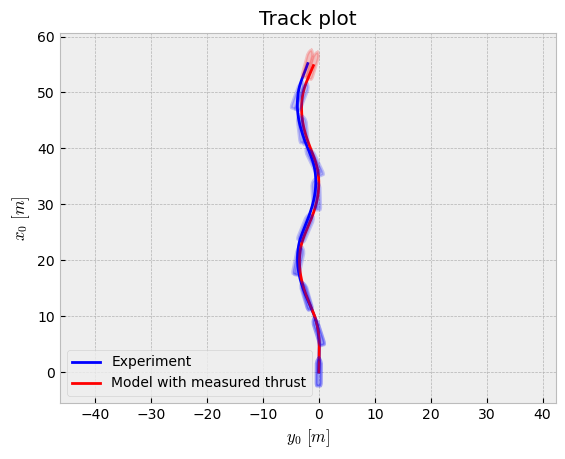

In [7]:
result_with_measured_thrust = model.simulate(data)

dataframes = {'Experiment':data,
              'Model with measured thrust':result_with_measured_thrust.result,
             }
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)


## Thrust prediction model

In [8]:
C0_w_p0,C1_w_p0,F_n = sp.symbols("C0_w_p0, C1_w_p0,F_n")
eq_w_p0 = sp.Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)

Assuming that $w_{p0}$ is a good model:

In [9]:
eq_F_n = sp.Eq(F_n,U/sp.sqrt(L*g))
eq_F_n

Eq(F_n, U/sqrt(L*g))

In [10]:
eq_w_p0 = eq_w_p0.subs(F_n, eq_F_n.rhs)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [11]:
eq_w_p = eq_w_p0.subs(w_p0,w_p)
eq_w_p

Eq(w_p, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [12]:
eqs = [eq_T,eq_K_T, eq_J, eq_w_p]
solution = sp.solve(eqs, thrust_propeller, K_T, J, w_p, dict=True)
eq = sp.Eq(thrust_propeller,n_prop*solution[0][thrust_propeller])
eq

Eq(thrust_propeller, D**2*n_prop*rho*(C0_w_p0**2*L*g*k_2*u**2 + 2*C0_w_p0*C1_w_p0*U*k_2*u**2*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev*u - 2*C0_w_p0*L*g*k_2*u**2 + C1_w_p0**2*U**2*k_2*u**2 - C1_w_p0*D*U*k_1*rev*u*sqrt(L*g) - 2*C1_w_p0*U*k_2*u**2*sqrt(L*g) + D**2*L*g*k_0*rev**2 + D*L*g*k_1*rev*u + L*g*k_2*u**2)/(L*g))

In [13]:
lambda_thrust = lambdify(eq.rhs)

In [14]:
params = {'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463}
data_predict_w0 = data.copy()
data_predict_w0['thrust'] = run(function=lambda_thrust, inputs=data_predict_w0, **ship_data, **params)

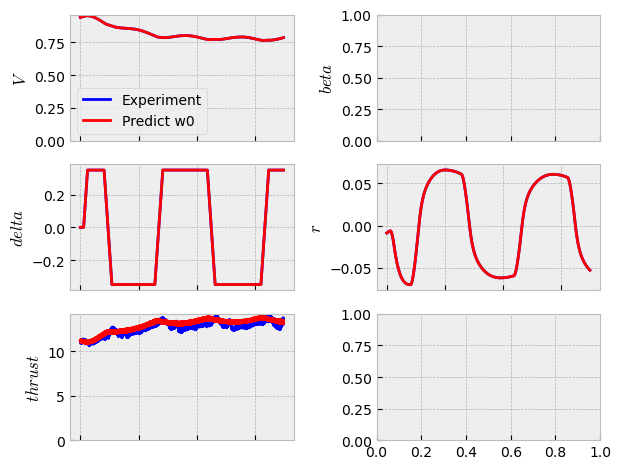

In [15]:
dataframes={'Experiment':data,
           'Predict w0': data_predict_w0,
           }
plot(dataframes=dataframes, keys=['thrust','V','beta','r','delta']);

## Add the thrust prediction to the simulation model

In [16]:
parameters = dict(model.parameters.copy())
parameters.update(params)
parameters['g'] = g_

model_with_propeller = ModelSimulatorWithPropeller(simulator=model, 
                                                   parameters=parameters, 
                                                   ship_parameters=model.ship_parameters, 
                                                   prime_system=model.prime_system, 
                                                   lambda_thrust=lambda_thrust)
model_with_propeller.parameters = parameters
#model_with_propeller.parameters['C0_w_p0'] = 0.5
model_with_propeller.ship_parameters['n_prop'] = ship_data['n_prop']

In [17]:
model_with_propeller.parameters = pd.Series(model_with_propeller.parameters)
model_loader["SLIC_propeller"] = model_with_propeller
catalog.save(f"wPCC.models", model_loader)

[06/01/23 08:45:32] INFO     Saving data to 'wPCC.models' (PartitionedDataSet)...               ]8;id=22873;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=554708;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [18]:
model_with_propeller.parameters

Xudot           0.000179
Xdeltadelta    -0.002894
Xrr            -0.001477
Xthrust         0.883000
Xuu             0.019964
Xu             -0.020788
Xvr            -0.007750
Yrdot          -0.000303
Yvdot          -0.006109
Ydelta          0.004123
Yr              0.064686
Ythrust         0.000000
Yu             -0.000027
Yv             -0.020338
Ythrustdelta    0.009268
Yur            -0.066078
Yvvdelta        0.039627
Nrdot          -0.000299
Nvdot          -0.000128
Ndelta         -0.001992
Nr             -0.037487
Nthrust         0.000000
Nu             -0.000003
Nv             -0.000053
Nthrustdelta   -0.004477
Nur             0.035673
Nvvdelta       -0.019141
C0_w_p0         0.103786
C1_w_p0         0.246905
k_0             0.576582
k_1            -0.368368
k_2            -0.075430
g               9.810000
dtype: float64

In [19]:
data_ = data.drop(columns=['thrust'])
result_with_predicted_thrust = model_with_propeller.simulate(data_)

In [20]:
model_with_propeller

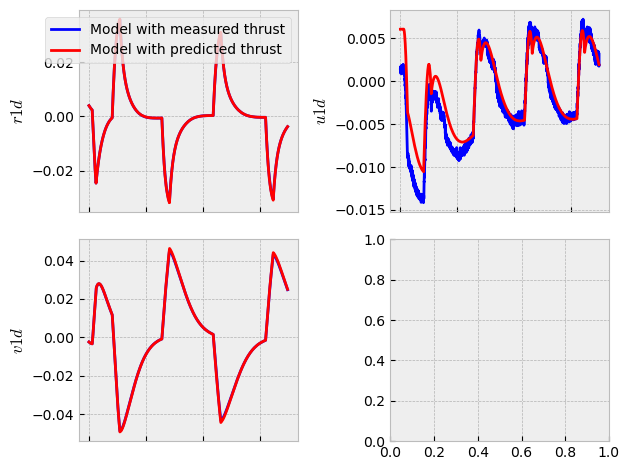

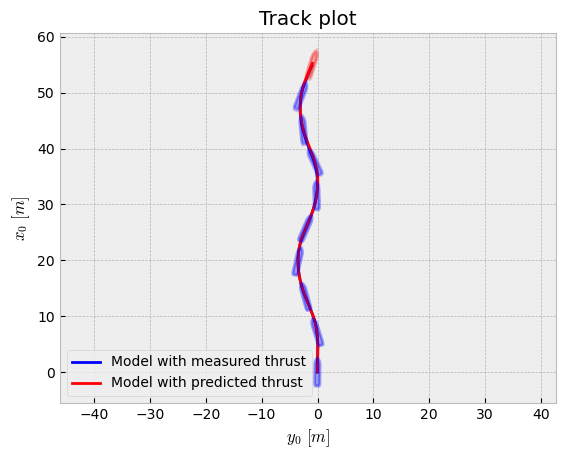

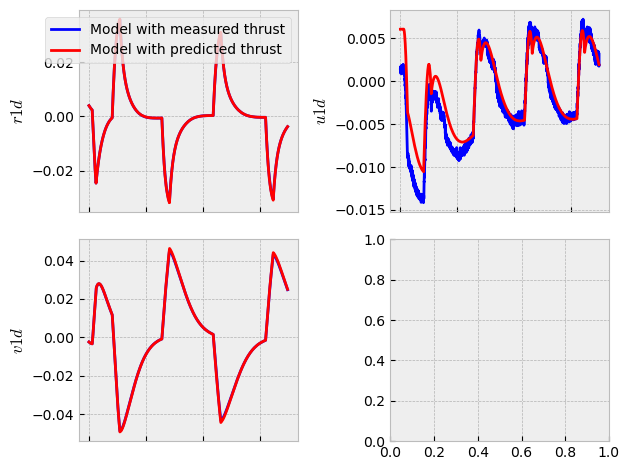

In [21]:
dataframes = {#'Experiment':data,
              'Model with measured thrust':result_with_measured_thrust.result,
              'Model with predicted thrust':result_with_predicted_thrust.result,
             }
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes,keys=['u1d','v1d','r1d'])

## Model the propeller power

In [22]:
eq_P_d

Eq(P_d, 2*pi*D**5*K_Q*n_prop*rev**3*rho/eta_r)

In [23]:
eq_K_Q

Eq(K_Q, J*k_q1 + k_q0)

In [24]:
eq_J

Eq(J, u*(1 - w_p)/(D*rev))

In [25]:
eq_w_p

Eq(w_p, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [26]:
eqs = [eq_P_d, eq_K_Q, eq_J, eq_w_p]
eq_P_d_expanded = sp.Eq(P_d,sp.solve(eqs, P_d, K_Q, J, w_p)[P_d].subs(eta_r,1))
eq_P_d_expanded

Eq(P_d, (-2*pi*C0_w_p0*D**4*k_q1*n_prop*rev**2*rho*u*sqrt(L*g) - 2*pi*C1_w_p0*D**4*U*k_q1*n_prop*rev**2*rho*u + 2*pi*D**5*k_q0*n_prop*rev**3*rho*sqrt(L*g) + 2*pi*D**4*k_q1*n_prop*rev**2*rho*u*sqrt(L*g))/sqrt(L*g))

In [27]:
lambda_P_d_expanded = lambdify(eq_P_d_expanded.rhs)

In [28]:
kq_params = {'k_q0': 0.10712327968482076, 'k_q1': -0.07566495730452033}
parameters = dict(model_with_propeller.parameters)
parameters.update(kq_params)
model_with_propeller.parameters = parameters
data['thrust_propeller'] = data['thrust']/ship_data['n_prop']
data['P_d'] = run(lambda_P_d_expanded, inputs=data, **model_with_propeller.ship_parameters, **model_with_propeller.parameters)

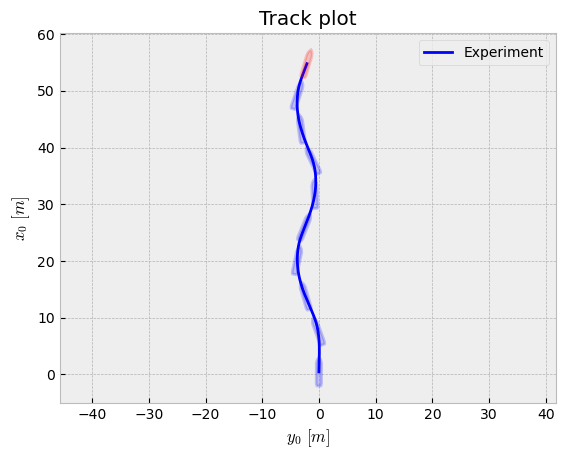

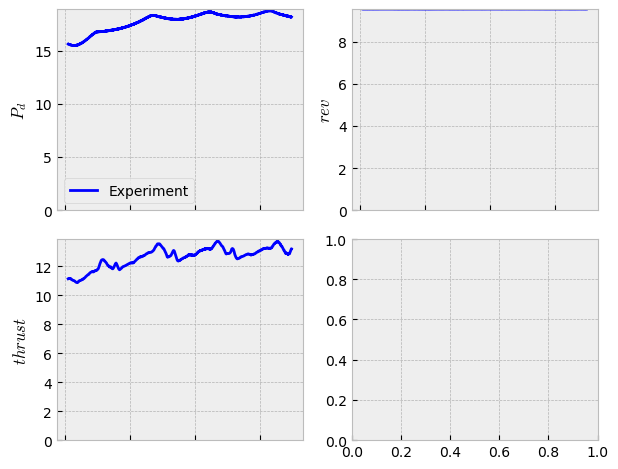

In [29]:
dataframes = {'Experiment':data.rolling(100).mean().dropna(),
             }
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes,keys=['thrust','P_d','rev']);

## Constant Power
Similar to what the 7m presumably uses.

In [30]:
eqs = [eq_P_d, eq_K_Q, eq_J]
eq_P_d_expanded = sp.Eq(P_d,sp.solve(eqs, P_d, K_Q, J)[P_d].subs(eta_r,1))
eq_P_d_expanded

Eq(P_d, 2*pi*D**5*k_q0*n_prop*rev**3*rho - 2*pi*D**4*k_q1*n_prop*rev**2*rho*u*w_p + 2*pi*D**4*k_q1*n_prop*rev**2*rho*u)

In [31]:
eq_P_d_naiv = eq_P_d_expanded.subs([
    (D,ship_data['D']),
    (k_q0,model_with_propeller.parameters['k_q0']),
    (k_q1,model_with_propeller.parameters['k_q1']),
    (n_prop,sp.Rational(2)),
    (rho,ship_data['rho']),
    (w_p,0.15),
    (u,float(data['u'].mean())),
    (sp.pi, np.pi),
                     ])
eq_P_d_naiv

Eq(P_d, 0.0354370585469702*rev**3 - 0.141567620643182*rev**2)

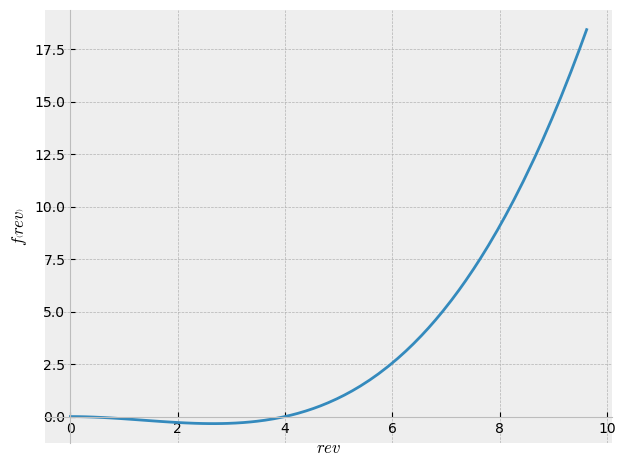

In [32]:
sp.plotting.plot(eq_P_d_naiv.rhs, (rev,0,float(data['rev'].max())))

In [33]:
eq_rev = sp.Eq(rev, sp.re(sp.simplify(sp.solve(eq_P_d_naiv, rev)[1])))
lambda_rev = lambdify(eq_rev.rhs)

In [34]:
eq_rev

Eq(rev, (-(1.20820543143214*((-P_d + re((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5) - 0.167356543604182)**2 + im((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5)**2)**(1/6)*sin(atan2(im((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5), -P_d + re((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5) - 0.167356543604182)/3) - 2.09267319322115*((-P_d + re((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5) - 0.167356543604182)**2 + im((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5)**2)**(1/6)*cos(atan2(im((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5), -P_d + re((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5) - 0.167356543604182)/3))*((-P_d + re((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5) - 0.167356543604182)**2 + im((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5)**2)**(1/6)*sin(atan2(im((P_d**2 + 0.334713087208365*P_d - 6.93889390390723e-18)**0.5), -P_d

In [35]:
eq_rev.subs(P_d,10).rhs.evalf(chop=True)

8.19588417778263

In [36]:
lambda_rev(10)

8.195884177782544

In [37]:
eq_P_d_naiv2 = eq_P_d_expanded.subs([
    (D,ship_data['D']),
    (k_q0,model_with_propeller.parameters['k_q0']),
    (k_q1,model_with_propeller.parameters['k_q1']),
    (n_prop,sp.Rational(2)),
    (rho,ship_data['rho']),
    #(w_p,0.15),
    #(u,float(data['u'].mean())),
    #(sp.pi, np.pi),
                     ])
eq_P_d_naiv2

Eq(P_d, 0.0112799660727744*pi*rev**3 + 0.0656516938927343*pi*rev**2*u*w_p - 0.0656516938927343*pi*rev**2*u)

In [38]:
eq_rev2 = sp.Eq(rev, sp.re(sp.simplify(sp.solve(eq_P_d_naiv2, rev)[1])))
lambda_rev2 = lambdify(sp.re(eq_rev2.rhs))

In [39]:
lambda_rev2(P_d=10, u=data['u'].mean(), w_p=0.15)

8.19588417778534

<Axes: xlabel='rev'>

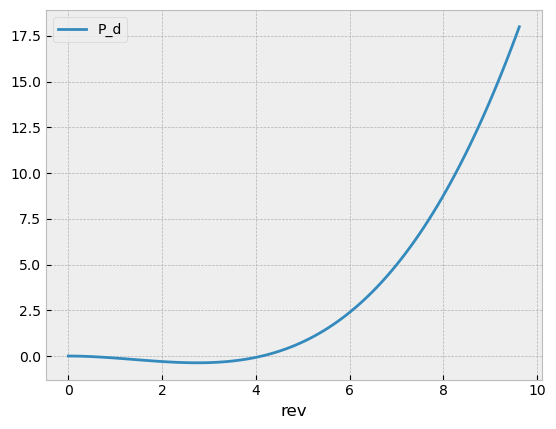

In [40]:
df_ = pd.DataFrame()
df_['rev'] = np.linspace(0,data['rev'].max(),100)
df_['U'] = df_['u'] = data['U'].mean()

df_['P_d'] = run(lambda_P_d_expanded, inputs=df_, **model_with_propeller.ship_parameters, **model_with_propeller.parameters)

df_.plot(x='rev', y='P_d')

In [41]:
run(lambda_rev2, inputs=data, **model_with_propeller.ship_parameters, **model_with_propeller.parameters, w_p=0.15)

0.000000     9.544833
0.010000     9.549468
0.020000     9.544353
0.030000     9.520598
0.040000     9.526626
               ...   
69.780004    9.476158
69.790004    9.505335
69.800004    9.513889
69.810004    9.555734
69.820004    9.571768
Name: P_d, Length: 6983, dtype: float64

In [42]:
lambda_w_p

<function _lambdifygenerated(D, k_1, k_2, u, k_0, thrust_propeller, rev, rho)>

In [43]:
data2 = data.copy()
data2['P_d'] = data['P_d'].iloc[0]
data2['w_p'] = run(lambda_w_p, inputs=data2, **model_with_propeller.ship_parameters, **model_with_propeller.parameters)
data2['rev'] = run(lambda_rev2, inputs=data2, **model_with_propeller.ship_parameters, **model_with_propeller.parameters)
data2['P_d'] = run(lambda_P_d_expanded, inputs=data2, **model_with_propeller.ship_parameters, **model_with_propeller.parameters)


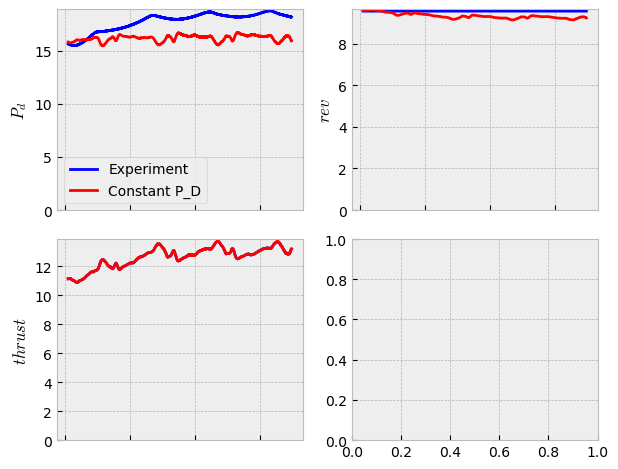

In [44]:
dataframes = {'Experiment':data.rolling(100).mean().dropna(),
              'Constant P_D': data2.rolling(100).mean().dropna()
             }

plot(dataframes,keys=['thrust','P_d','rev']);